# Packages

In [2]:
import torch
import time
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torch import optim
import torch.nn as nn
from torchvision import models
from torch.optim import lr_scheduler

from torchvision import datasets
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2
from PIL import Image

import numpy as np
import pandas as pd
import os
import imageio
import array as ar
import numpy as np
import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


In [4]:
pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

     / 297 kB 1.8 MB/s
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3839 sha256=94c29bbf28b11a3247388d66d51f8c778c4b67cfff1b388fc8860b7123c4a129
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhaff2nb/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler


In [5]:
from torchsampler import ImbalancedDatasetSampler

# Dataset

In [6]:
pip install split-folders

In [7]:
import splitfolders

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip '/content/drive/MyDrive/Malware detection/malimg_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: malimg_paper_dataset_imgs/Allaple.L/06524ebf396548004410f99a4dde2e54.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/06524f125eece7a54370609287188980.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/0652f1f4bad2c5c928080bc90db86ed1.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/0654748b4cc3330deef95ab0af4041cf.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/06549b73968ac1fc1e8eb54dddb10833.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/065513aa17b61f57cf793703a725c015.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/06583d83c5278fac7cd20c015780c1d0.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/0658876855197e86e417ba8a84d298ec.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/06598930132128de200841974164a858.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/065a7e3f38d8cc3ca056b4f5fc272643.png  
  inflating: malimg_paper_dataset_imgs/Allaple.L/065d1f12c517c06d5a51

In [9]:
splitfolders.ratio("/content/malimg_paper_dataset_imgs", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 9339 files [00:12, 732.10 files/s] 


# Batch Conversion

In [10]:
data_dir = '/content/output'
batch_size = 32

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Balancer


In [12]:
def dataset_balancer(root_dir, dataset):
    class_weights = []
    for root, subdir, files in os.walk(root_dir):
        if len(files) > 0:
            class_weights.append(1/len(files))
            print(f'Rooot:{root}, SubDir:{subdir}, No of files in SubDir:{len(files)}')

    sample_weights = [0] * len(dataset)

    for idx, (data, label) in enumerate(dataset):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(sample_weights, num_samples=
                                    len(sample_weights), replacement=True)
    print(f'class_weights : {class_weights}')
    print(f'sample_weights : {sample_weights}')
    return sampler

## Main

In [13]:
dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
# samplers = {x: dataset_balancer(os.path.join(data_dir,x), dataset[x])
#                                 for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size,
                                             sampler=ImbalancedDatasetSampler(dataset[x]), num_workers=4 )
                  for x in ['train', 'val', 'test']} 
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Representation of a Batch of Images

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


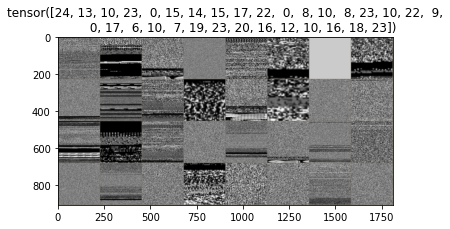

In [15]:
#see the images from dataloader
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#title = list(class_names[x] for x in classes)
#view a batch image
imshow(out, classes)

# Transfer Learning and Model Tuning

In [16]:
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [17]:
for parms in model.parameters():
  parms.requires_grad=False

In [18]:
#new Mode for 60-20-20 datsset split
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,64),
    nn.ReLU(),
    nn.Linear(64,25),
    nn.LogSoftmax()
)
model.fc = classifier

In [19]:
for param in model.parameters():
    if param.requires_grad:  
        print(param.shape)

torch.Size([512, 2048])
torch.Size([512])
torch.Size([64, 512])
torch.Size([64])
torch.Size([25, 64])
torch.Size([25])


# Training the Model

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
#Training Hyperparameters

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

# Optimisation of model parameters
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1) 

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been de

train Loss: 1.6702 Acc: 0.4576
val Loss: 1.0200 Acc: 0.6219

Training complete in 2m 13s
Best val Acc: 0.621885


# 11 Saving Model

In [23]:
PATH = '/content/drive/MyDrive/Malware detection/Malware_dect-sampler_new.pth'

model.epochs = num_epochs = 1 
checkpoint = {
              #'epoch': model_ft.epochs,
              'model_state_dict': model_ft.state_dict(),
             'optimizer_state_dict': optimizer_ft.state_dict(),
              }
torch.save(checkpoint, PATH)

# Comparison with other Neural Networks

## Resnet 18

### Transfer Learning and Model Tuning

In [24]:
model1 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [25]:
for parms in model1.parameters():
  parms.requires_grad=False

In [26]:
#new Mode for 60-20-20 datsset split
classifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64,25),
    nn.LogSoftmax()
)
model1.fc = classifier

In [27]:
for param in model1.parameters():
    if param.requires_grad:  
        print(param.shape)

torch.Size([256, 512])
torch.Size([256])
torch.Size([64, 256])
torch.Size([64])
torch.Size([25, 64])
torch.Size([25])


### Training the Model

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
#Training Hyperparameters

model1 = model1.to(device)
loss_fn1 = nn.CrossEntropyLoss()

# Optimisation of model parameters
optimizer_ft1 = optim.Adam(model1.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer_ft1, step_size=7, gamma=0.1)

In [30]:
model_ft1 = train_model(model1, loss_fn1, optimizer_ft1, exp_lr_scheduler1,
                       num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 1.8316 Acc: 0.4058
val Loss: 1.1580 Acc: 0.5840

Training complete in 0m 48s
Best val Acc: 0.583965


### 11 Saving Model

In [31]:
PATH = '/content/drive/MyDrive/Malware detection/Malware_dect_res18.pth'

# model1.epochs = num_epochs
checkpoint = {
              #'epoch': model_ft.epochs,
              'model_state_dict': model_ft1.state_dict(),
             'optimizer_state_dict': optimizer_ft1.state_dict(),
              }
torch.save(checkpoint, PATH)

## Resnet 50


### Transfer Learning and Model Tuning

In [32]:
model2 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [33]:
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
for parms in model2.parameters():
  parms.requires_grad=False

In [35]:
#new Mode for 60-20-20 datsset split
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,64),
    nn.ReLU(),
    nn.Linear(64,25),
    nn.LogSoftmax()
)
model2.fc = classifier

In [36]:
for param in model2.parameters():
    if param.requires_grad:  
        print(param.shape)

torch.Size([512, 2048])
torch.Size([512])
torch.Size([64, 512])
torch.Size([64])
torch.Size([25, 64])
torch.Size([25])


### Training the Model

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
#Training Hyperparameters

model2 = model2.to(device)
loss_fn2 = nn.CrossEntropyLoss()

# Optimisation of model parameters
optimizer_ft2 = optim.Adam(model2.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)

In [39]:
model_ft2 = train_model(model2, loss_fn2, optimizer_ft2, exp_lr_scheduler2,
                       num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 1.8203 Acc: 0.4212
val Loss: 1.2121 Acc: 0.5742

Training complete in 1m 3s
Best val Acc: 0.574215


### 11 Saving Model

In [40]:
PATH = '/content/drive/MyDrive/Malware detection/Malware_dect-res50.pth'

# model.epochs = num_epochs
checkpoint = {
              #'epoch': model_ft.epochs,
              'model_state_dict': model_ft2.state_dict(),
             'optimizer_state_dict': optimizer_ft2.state_dict(),
              }
torch.save(checkpoint, PATH)

## VGG -16


### Transfer Learning and Model Tuning

In [41]:
model3 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [42]:
print(model3)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [43]:
for parms in model3.parameters():
  parms.requires_grad=False

In [44]:
model3.classifier[6] = nn.Linear(in_features=4096, out_features=25, bias=True)

In [45]:
for param in model3.parameters():
    if param.requires_grad:  
        print(param.shape)

torch.Size([25, 4096])
torch.Size([25])


### Training the Model

In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [47]:
#Training Hyperparameters

model3 = model3.to(device)
loss_fn3 = nn.CrossEntropyLoss()

# Optimisation of model parameters
optimizer_ft3 = optim.Adam(model3.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer_ft3, step_size=7, gamma=0.1)

In [48]:
model_ft3 = train_model(model3, loss_fn3, optimizer_ft3, exp_lr_scheduler3,
                       num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.3718 Acc: 0.5491
val Loss: 1.0386 Acc: 0.6392

Training complete in 1m 21s
Best val Acc: 0.639220


### 11 Saving Model

In [49]:
PATH = '/content/drive/MyDrive/Malware detection/Malware_dect-vgg16.pth'

# model.epochs = num_epochs
checkpoint = {
              #'epoch': model_ft.epochs,
              'model_state_dict': model_ft3.state_dict(),
             'optimizer_state_dict': optimizer_ft3.state_dict(),
              }
torch.save(checkpoint, PATH)

# Test _Main

In [50]:
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    del images, labels, output  #Freeing GPU memory and cache for preventing VRAM overflow 
    torch.cuda.empty_cache()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

In [51]:
test(model_ft, dataloaders, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Testing Accuracy: 0.019
Testing Accuracy: 0.041
Testing Accuracy: 0.068
Testing Accuracy: 0.092
Testing Accuracy: 0.103
Testing Accuracy: 0.126
Testing Accuracy: 0.145
Testing Accuracy: 0.168
Testing Accuracy: 0.191
Testing Accuracy: 0.213
Testing Accuracy: 0.234
Testing Accuracy: 0.253
Testing Accuracy: 0.281
Testing Accuracy: 0.303
Testing Accuracy: 0.324
Testing Accuracy: 0.346
Testing Accuracy: 0.366
Testing Accuracy: 0.381
Testing Accuracy: 0.408
Testing Accuracy: 0.430
Testing Accuracy: 0.447
Testing Accuracy: 0.468
Testing Accuracy: 0.492
Testing Accuracy: 0.514
Testing Accuracy: 0.534
Testing Accuracy: 0.555
Testing Accuracy: 0.573
Testing Accuracy: 0.594
Testing Accuracy: 0.616
Testing Accuracy: 0.640


# Load Model


In [57]:
# '/content/drive/MyDrive/Malware detection/Malware_dect.pth'
#  '/content/drive/MyDrive/Malware detection/Malware_dect-84.pth'

PATH = '/content/drive/MyDrive/Malware detection/Malware_dect-sampler_new.pth'
def load_checkpoint(filepath):

  chkpt = torch.load(filepath, map_location='cpu')
  model = models.resnet152()
  for parms in model.parameters():
    parms.requires_grad=False
  classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Linear(512,64),
      nn.ReLU(),
      nn.Linear(64,25),
      nn.LogSoftmax()
  )
  model.fc = classifier

  model.load_state_dict(chkpt['model_state_dict'])
  model = model.to('cpu')

  print('LOading Done')
  return model

loaded_model = load_checkpoint(PATH)

LOading Done


# Inference

In [58]:
classifications = [
                  "Adialer.C dialer",
                  "Agent.FYI bd", 
                  "Allaple.A worm", 
                  "Allaple.L worm", 
                  "Alueron.gen!J trojan", 
                  "Autorun.K worm", 
                  "C2LOP.gen!g trojan", 
                  "C2LOP.P trojan", 
                  "Dialplatform.B dialer", 
                  "Dontovo.A dl", 
                  "Fakerean rogue", 
                  "Instantaccess dialer", 
                  "Lolyda.AA1 pws", 
                  "Lolyda.AA2 pws", 
                  "Lolyda.AA3 pws", 
                  "Lolyda.AT pws", 
                  "Malex.gen!J trojan", 
                  "Obfuscator.AD dl", 
                  "Rbot!gen bd", 
                  "Skintrim.N trojan",
                  "Swizzor.gen!E dl", 
                  "Swizzor.gen!I dl", 
                  "VB.AT worm", 
                  "Wintrim.BX dl",
                  "Yuner.A worm" 
]

In [59]:
def process_file(filename):
  f = open(fname, 'rb')
  ln = os.path.getsize(fname)
  width =256
  rem = ln % width 
  a =  ar.array("B") 
  a.fromfile(f,ln-rem)
  f.close()
  g = np.reshape(a, (int(len(a)/width),width))
  imageio.imwrite('temp.png', g)

In [60]:
def preprocess_data(image):
  preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  image = preprocess(image)
  print(image.size)
  image = torch.unsqueeze(image, 0) # Adding batch format for the image dimension [3,224,224] -> [1,3,224,224]
  # image = image.to(device)
  return image

In [61]:
def top_five_predections(prob):
  top5 = torch.topk(prob, 5)
  top5
  values, indeces = torch.topk(prob, 5) # Extraction of top 5 predicted categories values and their classes
  np_values = values.squeeze().detach().cpu().numpy()
  np_indeces = indeces.squeeze().cpu().numpy()
  return np_values,np_indeces
  

In [62]:
def prediction(img):
  loaded_model.eval()
  img = preprocess_data(img)
  probability = loaded_model(img) #Passing processed image to the saved model
  values, indeces = top_five_predections(probability)
  return values, indeces

In [63]:
def plot_predection(img):
  print(img.size)
  plt_values, plt_indeces = prediction(image)

  fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
  ax1.imshow(img)
  ax1.set_title('EXE Image')
  ax1.axis('off')

  
  
  y_pos = np.arange(len(plt_indeces))
  ax2.barh(y_pos, np.exp(plt_values))
  ax2.set_yticks(y_pos)
  ax2.set_yticklabels([classifications[x] for x in plt_indeces])
  ax2.invert_yaxis()

(384, 285)
<built-in method size of Tensor object at 0x7f5df029c960>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


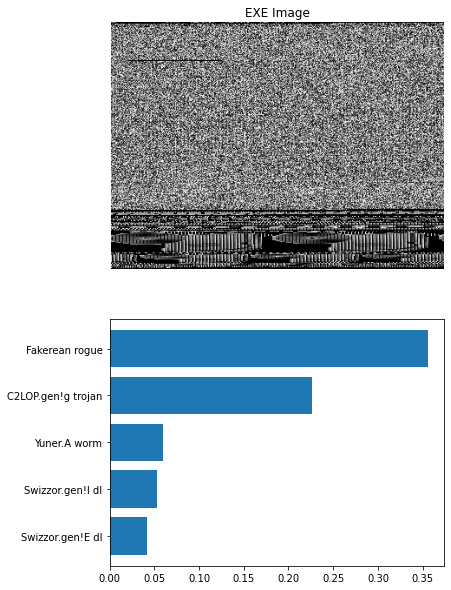

In [64]:
image =  cv2.imread('/content/output/test/Fakerean/037bbb3a2cb95b9e37d49eb2e80c995f.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(256, 246)
<built-in method size of Tensor object at 0x7f5df0090f50>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


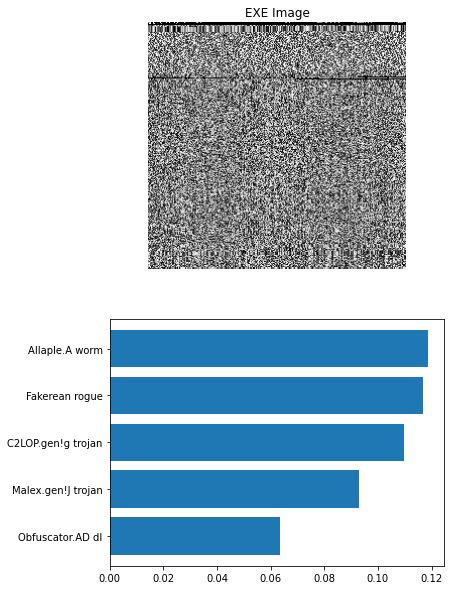

In [65]:
image =  cv2.imread('/content/output/test/Allaple.A/002b55a68bb77d4e9bde80b71385c17a.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(256, 22388)
<built-in method size of Tensor object at 0x7f5df033cdc0>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


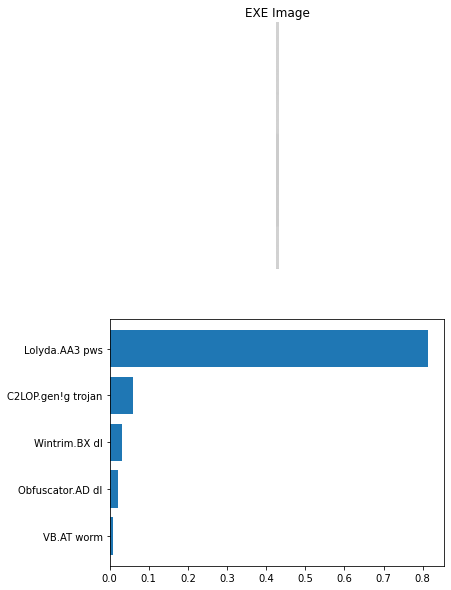

In [66]:
fname ='/content/0ACDbR5M3ZhBJajygTuf.bytes'
process_file(fname)
image =  cv2.imread('/content/temp.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(64, 456)
<built-in method size of Tensor object at 0x7f5ddc472640>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


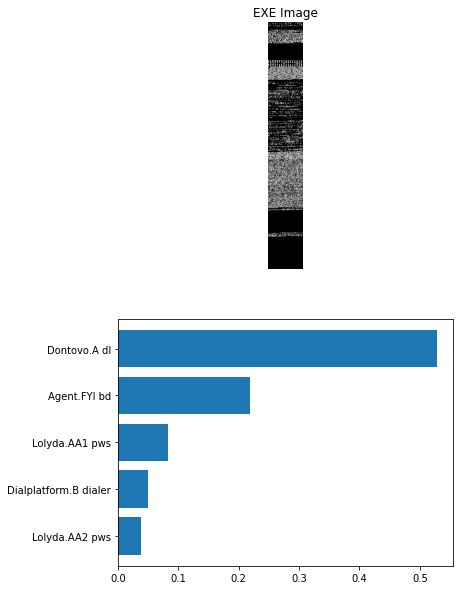

In [67]:
image =  cv2.imread('/content/output/test/Dontovo.A/00d62915bf860e3d5b9843294e3989da.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(64, 216)
<built-in method size of Tensor object at 0x7f5ddbb560a0>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


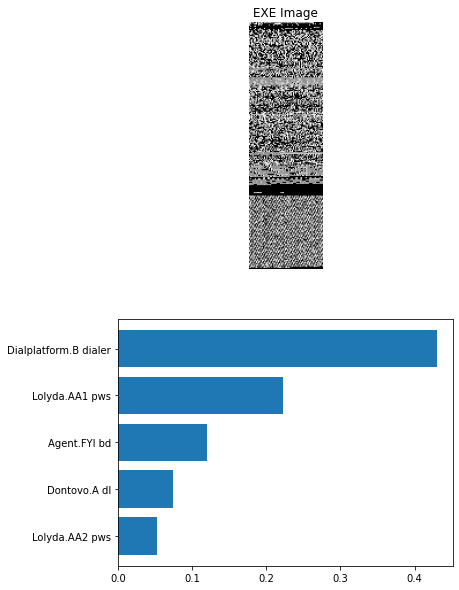

In [68]:
image =  cv2.imread('/content/output/test/Dialplatform.B/0078a70ff0c6a53ebd6a636b4afea711.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(384, 266)
<built-in method size of Tensor object at 0x7f5df0273a00>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


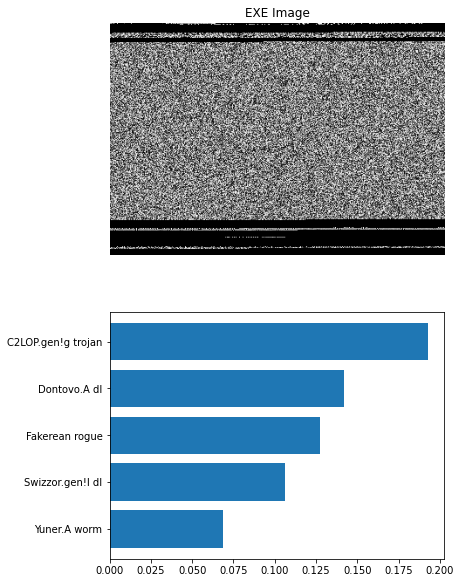

In [69]:
image =  cv2.imread('/content/output/test/Alueron.gen!J/03119d4ae0e9bbc358c9bfb8792ac49f.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(64, 258)
<built-in method size of Tensor object at 0x7f5df043b730>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


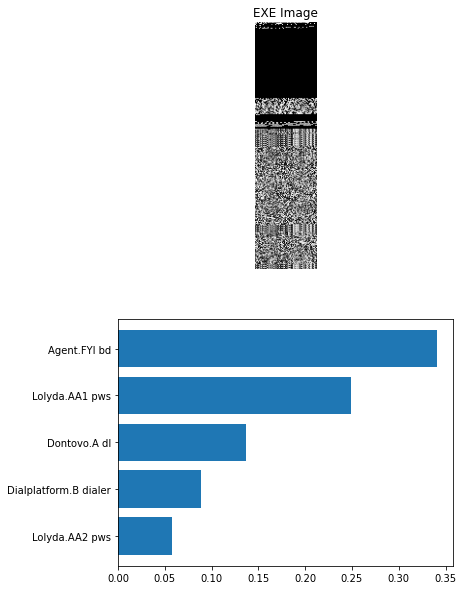

In [70]:
image =  cv2.imread('/content/output/test/Agent.FYI/00fa85c50b6e7c0cfc05fa041fc437ef.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(64, 400)
<built-in method size of Tensor object at 0x7f5df03c16e0>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


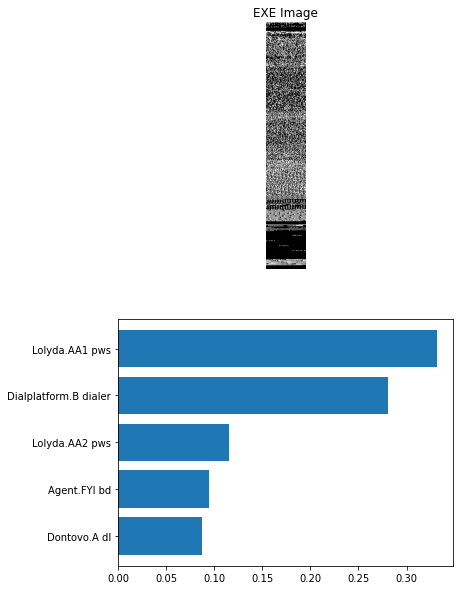

In [71]:
image =  cv2.imread('/content/output/test/Lolyda.AA1/007f83ef05075252252cbffa08717cfb.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(128, 288)
<built-in method size of Tensor object at 0x7f5df00aecd0>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


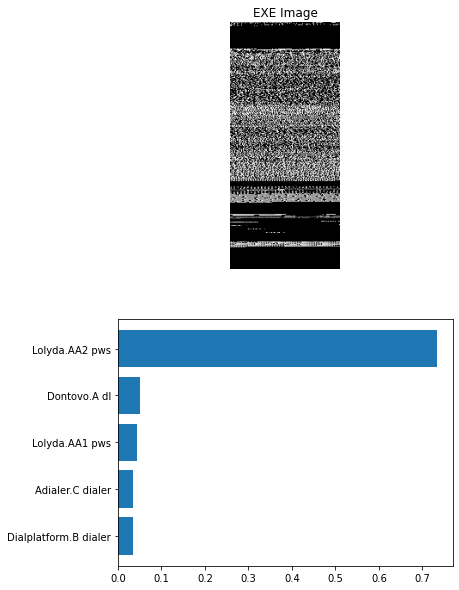

In [72]:
image =  cv2.imread('/content/output/test/Lolyda.AA2/0044d41a4db187677a849be084dc43b5.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(256, 4096)
<built-in method size of Tensor object at 0x7f5df2b94410>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


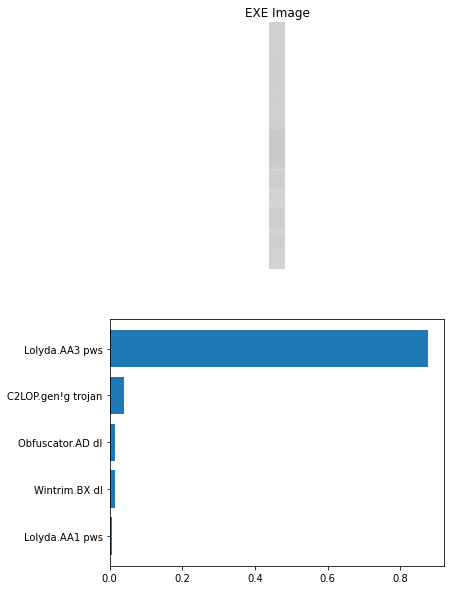

In [74]:
fname ='/content/0A32eTdBKayjCWhZqDOQ.bytes'
process_file(fname)
image =  cv2.imread('/content/temp.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(512, 479)
<built-in method size of Tensor object at 0x7f5ddd488690>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


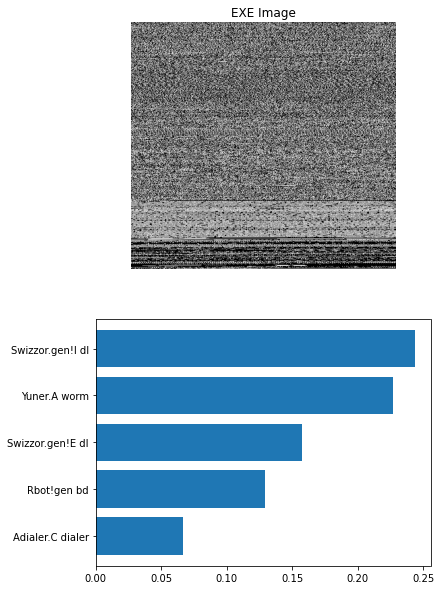

In [75]:
image =  cv2.imread('/content/output/test/Rbot!gen/7a40f3bd23a50f3c1b359212513a3de5.exe.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)

(512, 895)
<built-in method size of Tensor object at 0x7f5dd85fc410>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


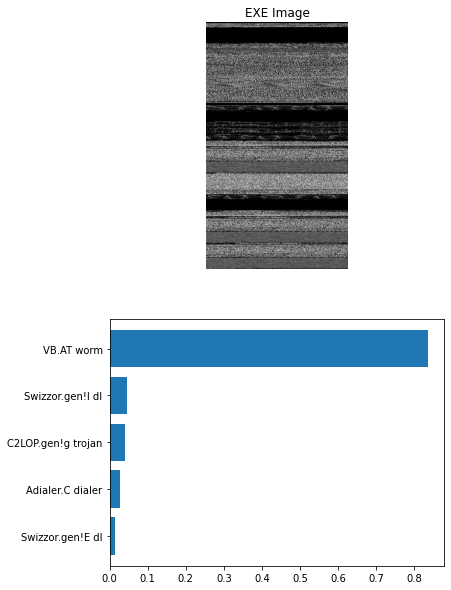

In [76]:
image =  cv2.imread('/content/output/test/VB.AT/0048a24b2c78dd604d70f0eae6f74545.png',0)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = Image.fromarray(np.uint8(image*255))
plot_predection(image)